# TP3
### Problema 2

O seguinte sistema dinâmico denota 4 inversores ($\,A, B, C, D\,$) que lêm um bit num canal input e escrevem num canal output uma transformação desse bit.

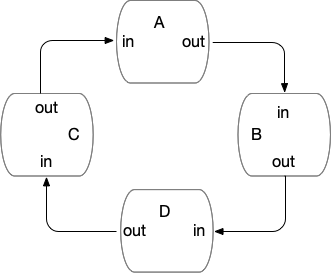

i. Cada inversor tem um bit $s$ de estado, inicializado  com um valor aleatório.
<br>
<br>
ii. Cada inversor é regido pelas seguintes transformações:
<br>
$\quad \textbf{invert}(in,out) $
<br>
$\quad \quad x ← \textbf{read}(in) $
<br>
$ \quad \quad s ← ¬x∥s←s⊕x​ $
<br>
$ \quad \quad \textbf{write}(out,s) $
<br>
<br>
iii. A escolha neste comando é sempre determinística; isto é, em cada inversor a escolha do comando a executar é sempre a mesma. Porém qual é essa escolha é determinada aleatoriamente na inicializarão do sistema.
<br>
<br>
iv. O estado do sistema é um duplo definido pelos 4 bits $s$, e é inicializado com um vetor aleatório em $\{0,1\}^4\;$.
<br>
<br>
v. O sistema termina em ERRO quando o estado do sistema for $\,(0,0,0,0)\,$.

Comecemos por importar as bibliotecas necessárias para a resolução do problema.

In [106]:
from pysmt.shortcuts import *
from pysmt.typing import INT

import itertools

### Modelação de Predicados
Os estados iniciais são caracterizados pelo seguinte predicado:
$$ pc = 0 \land (s_{A} = 0 \lor s_{A} = 1) \land (s_{B} = 0 \lor s_{B} = 1) \land (s_{C} = 0 \lor s_{C} = 1) \land (s_{D} = 0 \lor s_{D} = 1) $$
<br>
<br>
As transições possíveis no SFOTS são caracterizadas pelos seguintes predicados:
$$ pc = 0 \land pc' = 0 \land (s_{A} = 0 \lor s_{A} = 1) \land (s_{B} = 0 \lor s_{B} = 1) \land (s_{C} = 0 \lor s_{C} = 1) \land (s_{D} = 0 \lor s_{D} = 1) \land (s'_{A} = s_{A} ⊕ s_{C}) \land (s'_{B} = s_{B} ⊕ s_{A}) \land (s'_{D} = s_{D} ⊕ s_{B}) \land (s'_{C} = s_{C} ⊕ s_{D}) $$
$$\lor$$
$$ pc = 0 \land pc' = 0 \land (s_{A} = 0 \lor s_{A} = 1) \land (s_{B} = 0 \lor s_{B} = 1) \land (s_{C} = 0 \lor s_{C} = 1) \land (s_{D} = 0 \lor s_{D} = 1) \land (s'_{A} = \neg s_{C}) \land (s'_{B} = \neg s_{A}) \land (s'_{D} = \neg s_{B}) \land (s'_{C} = \neg s_{D}) $$
$$ \lor $$
$$ pc = 0 \land s_{A} = 0 \land s_{B} = 0 \land s_{C} = 0 \land s_{D} = 0 \land pc' = 1 \land s'_{A} = s_{A} \land s'_{B} = s_{B} \land s'_{C} = s_{C} \land s'_{D} = s_{D} $$
$$ \lor $$
$$ pc = 1 \land pc' = 1 \land s'_{A} = s_{A} \land s'_{B} = s_{B} \land s'_{C} = s_{C} \land s'_{D} = s_{D} $$

### Implementação
De seguida, definimos as funções necessárias para a resolução do problema.
<br>
<br>
A função `declare` cria a i-ésima cópia das variáveis de estado.

In [87]:
def declare(variaveis, i, s):
    
    state = {}
    for var in variaveis:
        state[var] = Symbol(var+s+str(i), INT)
        
    return state

In [33]:
def get_commands():
    #0 -> neg
    #1 -> xor
    dic = {}
    dic['A'] = Symbol('func_A', INT)
    dic['B'] = Symbol('func_B', INT)
    dic['C'] = Symbol('func_C', INT)
    dic['D'] = Symbol('func_D', INT)
    
    return dic

In [36]:
def init_commands(commands):
    return And(
            Or(Equals(commands['A'], Int(0)), Equals(commands['A'], Int(1))),
            Or(Equals(commands['B'], Int(0)), Equals(commands['B'], Int(1))),
            Or(Equals(commands['C'], Int(0)), Equals(commands['C'], Int(1))),
            Or(Equals(commands['D'], Int(0)), Equals(commands['D'], Int(1))))

A função `init` testa se um determinado estado, passado como parâmetro, é inicial.

In [27]:
def init(state):
    A = Or(Equals(state['A'], Int(0)),
           Equals(state['A'], Int(1)))
    
    B = Or(Equals(state['B'], Int(0)),
           Equals(state['B'], Int(1)))
    
    C = Or(Equals(state['C'], Int(0)),
           Equals(state['C'], Int(1)))
    
    D = Or(Equals(state['D'], Int(0)),
           Equals(state['D'], Int(1)))
    
    return And(Equals(state['pc'], Int(0)), A, B, C, D)

A função `xor` realiza a operação bitwise xor.

In [29]:
def xor(x, y, z):
    
    zero = Or(Equals(Plus(x, y), Int(2)), Equals(Plus(x, y), Int(0)))
    one = Equals(Plus(x, y), Int(1))
    
    
    return Ite(zero, Equals(z, Int(0)), Equals(z, Int(1)))

A função `trans` verifica se é possível transitar de um estado para outro, os quais são passados como parâmetros da função.

In [66]:
def trans(curr, prox, commands):
    
    t1 = And(
            Equals(curr['pc'], Int(0)),
            Equals(curr['A'], Int(0)),
            Equals(curr['B'], Int(0)),
            Equals(curr['C'], Int(0)),
            Equals(curr['D'], Int(0)),
            Equals(prox['pc'], Int(1)),
            Equals(prox['A'], curr['A']),
            Equals(prox['B'], curr['B']),
            Equals(prox['C'], curr['C']),
            Equals(prox['D'], curr['D']))
    
    A = Or(Equals(curr['A'], Int(0)),
           Equals(curr['A'], Int(1)))
    
    B = Or(Equals(curr['B'], Int(0)),
           Equals(curr['B'], Int(1)))
    
    C = Or(Equals(curr['C'], Int(0)),
           Equals(curr['C'], Int(1)))
    
    D = Or(Equals(curr['D'], Int(0)),
           Equals(curr['D'], Int(1)))
    
    func_A = Ite(
                Equals(commands['A'], Int(1)),
                xor(curr['A'], curr['C'], prox['A']),
                NotEquals(prox['A'], curr['C']))
    
    func_B = Ite(
                Equals(commands['B'], Int(1)),
                xor(curr['B'], curr['A'], prox['B']),
                NotEquals(prox['B'], curr['A']))
    
    func_C = Ite(
                Equals(commands['C'], Int(1)),
                xor(curr['C'], curr['D'], prox['C']),
                NotEquals(prox['C'], curr['D']))
    
    func_D = Ite(
                Equals(commands['D'], Int(1)),
                xor(curr['D'], curr['B'], prox['D']),
                NotEquals(prox['D'], curr['B']))
    
    t2 = And(
            Equals(curr['pc'], Int(0)),
            Equals(prox['pc'], Int(0)),
            A, B, C, D,
            GT(Plus(curr['A'], curr['B'], curr['C'], curr['D']), Int(0)), #pelo menos um inversor diferente de 0
            func_A, func_B, func_C, func_D)
    
    t3 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(1)),
            Equals(prox['A'], curr['A']),
            Equals(prox['B'], curr['B']),
            Equals(prox['C'], curr['C']),
            Equals(prox['D'], curr['D']))
    
    return Or(t1, t2, t3)
    

A função `invert_trans` recebe como argumento a função que codifica a relação de transição, devolvendo a sua inversa, ou seja, a relação de transição inversa.

In [111]:
def invert_trans(trans, curr, prox, commands):
    return trans(prox, curr, commands)

A função `error` testa se um determinado estado do programa é um possível estado de erro.

In [55]:
def error(state):
    
    t = And(Equals(state['pc'], Int(0)),
            Equals(state['A'], Int(0)),
            Equals(state['B'], Int(0)),
            Equals(state['C'], Int(0)),
            Equals(state['D'], Int(0)))
    
    return t

A função `genTrace` gera um possível traço de execução do programa com $n$ transições.

In [90]:
def genTrace(variaveis,init,trans,error,n):
    with Solver(name="z3") as s:
        commands = get_commands()
        
        S = [declare(variaveis, i, 'S') for i in range(n+1)]
        I = init(S[0])
        Tks = [trans(S[i], S[i+1], commands) for i in range(n)]
        
        if s.solve([init_commands(commands),I,And(Tks)]):
            for letter in commands:
                print(letter,"=",s.get_value(commands[letter]))
            
            for i in range(n):
                print("Estado:",i)
                for v in S[i]:
                    print("          ",v,'=',s.get_value(S[i][v]))

In [91]:
variaveis = ['pc', 'A', 'B', 'C', 'D']
genTrace(variaveis, init, trans, error, 10)

A = 0
B = 0
C = 1
D = 0
Estado: 0
           pc = 0
           A = 1
           B = 0
           C = 1
           D = 0
Estado: 1
           pc = 0
           A = 0
           B = 0
           C = 1
           D = 1
Estado: 2
           pc = 0
           A = 0
           B = 1
           C = 0
           D = 1
Estado: 3
           pc = 0
           A = 1
           B = 1
           C = 1
           D = 0
Estado: 4
           pc = 0
           A = 0
           B = 0
           C = 1
           D = 0
Estado: 5
           pc = 0
           A = 0
           B = 1
           C = 1
           D = 1
Estado: 6
           pc = 0
           A = 0
           B = 1
           C = 0
           D = 0
Estado: 7
           pc = 0
           A = 1
           B = 1
           C = 0
           D = 0
Estado: 8
           pc = 0
           A = 1
           B = 0
           C = 0
           D = 0
Estado: 9
           pc = 0
           A = 1
           B = 0
           C = 0
           D = 1


In [92]:
def bitvec_not_null(state):
    return GT(Plus(state['A'], state['B'], state['C'], state['D']), Int(0))

In [100]:
def bmc(declare, init, trans, inv, K):
    for k in range(1, K+1):
        with Solver(name = "z3") as solver:
            commands = get_commands()
            
            trace = [declare(variaveis, i, 'S') for i in range(k)]
            
            solver.add_assertion(init(trace[0]))
            solver.add_assertion(init_commands(commands))
            
            for i in range(k-1):
                solver.add_assertion(trans(trace[i], trace[i+1], commands))
                
            solver.add_assertion(Not(And(inv(trace[i]) for i in range(k-1))))
            
            if solver.solve():
                print("A propriedade não é um invariante")
                return
        
    print(f"O invariante mantém-se nos primeiros {k} passos")

In [102]:
bmc(declare, init, trans, bitvec_not_null, 10)

A propriedade não é um invariante


In [105]:
def same(state1,state2):
    return And([Equals(state1[x],state2[x]) for x in state1])


def rename(form,state):
    vs = get_free_variables(form)
    pairs = [ (x,state[baseName(x.symbol_name())]) for x in vs ]
    return form.substitute(dict(pairs))


def baseName(s):
    return ''.join(list(itertools.takewhile(lambda x: x!='!', s)))

In [115]:
def model_checking(variaveis, declare, init, trans, error, N, M):
    with Solver(name="z3") as s:
        commands = get_commands()
        
        X = [declare(variaveis,i,'X') for i in range(N+1)]
        Y = [declare(variaveis,i,'Y') for i in range(M+1)]
        
        order = sorted([(a,b) for a in range(1,N+1) for b in range(1,M+1)],key=lambda tup:tup[0]+tup[1]) 
        
        for (n,m) in order:
             
            # completar
            Tn = And([trans(X[i], X[i+1], commands) for i in range(n)])
            I = init(X[0])
            Rn = And(I, Tn)
            
            Bm = And(invert_trans(trans, Y[i], Y[i+1], commands) for i in range(m))
            E = error(Y[0])
            Um = And(E, Bm)
            
            Vnm = And(Rn, same(X[n], Y[m]), Um)
            
            if s.solve([Vnm, init_commands(commands)]):
                print("unsafe")
                return
            else:
                C = binary_interpolant(And(Rn, same(X[n], Y[m])), Um)
                if C is None:
                    print("interpolant None")
                    break
                C0 = rename(C, X[0])
                C1 = rename(C, X[1])
                T = trans1(X[0], X[1])
                if not s.solve([C0,T,Not(C1)]):
                    print("safe")
                    return
                else:
                    
                    S = rename(C, X[n])
                    while True:
                        A = And(S, trans1(X[n], Y[m]))
                        if s.solve([A, Um]):
                            print("Não é possível encontrar um majorante")
                            break
                        else:
                            Cnew = binary_interpolant(A, Um)
                            Cn = rename(Cnew, X[n])
                            if s.solve([Cn, Not(S)]):
                                S = Or(S, Cn)
                            else:
                                print("safe")
                                return
                
        print("unknown")                   
        

model_checking(['pc','A', 'B', 'C', 'D'], declare, init, trans, error, 50, 50)     

unsafe
